In [ ]:
import sys

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
import gc
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
import warnings

warnings.filterwarnings("ignore")

DATA_ROOT_PATH = 'test_images'
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [14]:
class PredictGlobalConfig:
    restore_from = '../experiments/effdet5_ds_only_impact_master_23_12_2020-ft-2/best-checkpoint-015epoch.bin'
    num_workers = 4
    batch_size = 3
    
    #folder = '../experiments/effdet5_ds_only_impact_master_22_12_2020_ft'
    soft_nms = True
    
predict_config = PredictGlobalConfig

In [15]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
    )

In [16]:
class DatasetRetriever(Dataset):
    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'../data/train_images_all/{image_id}', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [17]:
def make_predictions(images, score_threshold=0.5):
    images = torch.stack(images).to(device).float()
    box_list = []
    score_list = []
    with torch.no_grad():
        det = net(images)#, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]   
            label = det[i].detach().cpu().numpy()[:,5]
            # useing only label = 2
            indexes = np.where((scores > score_threshold) & (label == 2))[0]
            #boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            #boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            box_list.append(boxes[indexes])
            score_list.append(scores[indexes])
    return box_list, score_list


In [18]:
!nvidia-smi

Thu Dec 24 12:24:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    On   | 00000000:05:00.0 Off |                  N/A |
|  0%   16C    P8    13W / 370W |      3MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   

In [19]:
device = torch.device('cuda:1')

In [20]:
def load_net(predict_config):
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.image_size = [512, 512]
    config.norm_kwargs = dict(eps=0.001, momentum=0.01)
    config.soft_nms = predict_config.soft_nms
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load(predict_config.restore_from, map_location=device)
    
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    
    net.reset_head(num_classes=2)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    net = DetBenchPredict(net)
    net.eval();
    return net.to(device)
#if IS_PRIVATE:
net = load_net(predict_config)

In [21]:
val_df = pd.read_csv('../data/evaluation_labels.csv')
imgs = val_df.image_name.unique()

In [22]:
val_df.loc[(val_df.impact == 2) & (val_df.confidence <= 1), 'impact'] = 1

In [23]:
val_df.loc[(val_df.impact == 2) & (val_df.visibility <= 0), 'impact'] = 1

In [24]:
dataset = DatasetRetriever(
    image_ids=np.array(imgs),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [25]:
import tqdm
result_image_ids = []
results_boxes = []
results_scores = []
for images, image_ids in tqdm.tqdm_notebook(data_loader):
    box_list, score_list = make_predictions(images, score_threshold=0.4)
    for i, image in enumerate(images):
        boxes = box_list[i]
        scores = score_list[i]
        image_id = image_ids[i]
        boxes[:, 0] = (boxes[:, 0] * 1280 / 512)
        boxes[:, 1] = (boxes[:, 1] * 720 / 512)
        boxes[:, 2] = (boxes[:, 2] * 1280 / 512)
        boxes[:, 3] = (boxes[:, 3] * 720 / 512)
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        boxes = boxes.astype(np.int32)
        boxes[:, 0] = boxes[:, 0].clip(min=0, max=1280-1)
        boxes[:, 2] = boxes[:, 2].clip(min=0, max=1280-1)
        boxes[:, 1] = boxes[:, 1].clip(min=0, max=720-1)
        boxes[:, 3] = boxes[:, 3].clip(min=0, max=720-1)
        result_image_ids += [image_id]*len(boxes)
        results_boxes.append(boxes)
        results_scores.append(scores)

In [26]:
box_df = pd.DataFrame(np.concatenate(results_boxes), columns=['left', 'top', 'width', 'height'])
test_df = pd.DataFrame({'scores':np.concatenate(results_scores), 'image_name':result_image_ids})
test_df = pd.concat([test_df, box_df], axis=1)
test_df['frame'] = test_df.image_name.apply(lambda x: int(x.split('_')[-1].split('.')[0]))
test_df['video'] = test_df.image_name.apply(lambda x: '_'.join(x.split('_')[:3])+'.mp4' )
test_df.shape

(3724, 8)

In [27]:
test_df.head()

,scores,image_name,left,top,width,height,frame,video
0,0.428721,57583_000082_Endzone_30.png,562,330,22,20,30,57583_000082_Endzone.mp4
1,0.419420,57583_000082_Endzone_31.png,564,328,23,21,31,57583_000082_Endzone.mp4
2,0.412025,57583_000082_Endzone_32.png,564,327,23,22,32,57583_000082_Endzone.mp4
3,0.416977,57583_000082_Endzone_40.png,442,321,21,17,40,57583_000082_Endzone.mp4
4,0.591048,57583_000082_Endzone_41.png,442,321,20,16,41,57583_000082_Endzone.mp4


In [28]:
def nms(scores, frames, x1, y1, x2, y2, thresh=0.5, fr_th=200):
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        frm = frames[order[1:]]

        inds = np.where((ovr <= thresh) | (abs(frm - frames[i]) > fr_th))[0]
        # inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [29]:
def filter_by_nms(test_df, tr=0.5, fr_tr=200):
    indices = []
    leave = 0
    for vid in test_df.video.unique():
        info = test_df[test_df.video ==vid]
        #print(info.columns)
        x1 = info['left'].values
        y1 = info['top'].values
        x2 = x1 + info['width'].values
        y2 = y1 + info['height'].values
        res = nms(info['scores'].values, info['frame'].values, x1, y1, x2, y2, tr, fr_tr)
        leave += len(res)
        #print(vid,' to_drop', info.shape[0]-len(res))
        indices_to_drop = info.index[list(set(list(range(info.shape[0]))) - set(res))]
        indices.extend(list(indices_to_drop))
    test_df= test_df.drop(index = indices)
    #print(leave, len(indices))
    return test_df
    
    

In [30]:
def iou(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
        return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union


def precision_calc(gt_boxes, pred_boxes):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[0] - box2[0])
            if dist > 4:
                continue
            iou_score = iou(box1[1:], box2[1:])

            if iou_score < 0.35:
                continue
            else:
                cost_matix[i, j] = 0

    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp = 0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i, j] == 0:
            tp += 1
        else:
            fp += 1
            fn += 1
    return tp, fp, fn

In [31]:
from scipy.optimize import linear_sum_assignment
def get_boxes(df):
    arr = df[['frame', 'left', 'top', 'width', 'height']].to_numpy()
    arr[:, 3] = arr[:,1] + arr[:, 3]
    arr[:, 4] = arr[:,2] + arr[:, 4]
    return arr

In [32]:
def calculate_metrics(test_df, val_df):
    ftp, ffp, ffn = [], [], []
    for vid in val_df.video.unique():
        #if vid.split('_')[-1].split('.')[0] == 'Endzone':
        #if vid.split('_')[-1].split('.')[0] == 'Sideline':
        #    continue
        pred_boxes = get_boxes(test_df[test_df.video == vid])
        gt_boxes = get_boxes(val_df[(val_df.video == vid) & (val_df.impact == 2)])
        tp, fp, fn = precision_calc(gt_boxes, pred_boxes)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f'{vid}:  TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {precision:.2f}, RECALL: {recall:.2f}, F1 SCORE: {f1_score:.2f}')
        ftp.append(tp)
        ffp.append(fp)
        ffn.append(fn)
    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    return tp, fp, fn, precision, recall, f1_score
    

In [116]:
# this code for checking
# check_video_df = test_df[test_df.video == '58095_004022_Endzone.mp4']
# check_video_df = val_df[(val_df.video == '58095_004022_Endzone.mp4') & (val_df.impact == 2)]
# check_video_df['frame'] = check_video_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)

171776
171791


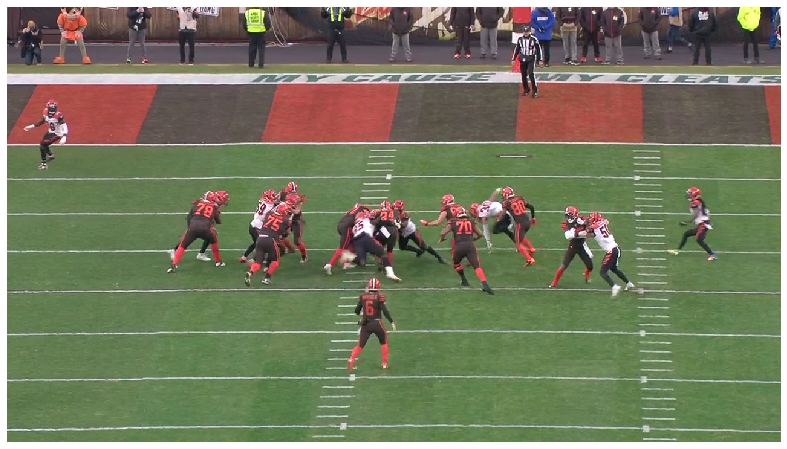

In [120]:
# check_video_df = check_video_df[check_video_df.frame == 176]
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# sample = cv2.cvtColor(cv2.imread('../data/train_images_all/58095_004022_Endzone_176.png'), cv2.COLOR_BGR2RGB)
# for index, row in check_video_df.iterrows():
#     print(index)
#     x1 = row['left']
#     y1 = row['top']
#     x2 = x1 + row['width']
#     y2 = y1 + row['height']
    
#     #cv2.rectangle(sample, (x1, y1), (x2, y2), (1, 0, 0), 3)
# ax.set_axis_off()
# ax.imshow(sample);

In [92]:
calculate_metrics(test_df, val_df)

57583_000082_Endzone.mp4:  TP: 7, FP: 103, FN: 13, PRECISION: 0.06, RECALL: 0.35, F1 SCORE: 0.11
57586_004152_Endzone.mp4:  TP: 6, FP: 39, FN: 4, PRECISION: 0.13, RECALL: 0.60, F1 SCORE: 0.22
57679_003316_Endzone.mp4:  TP: 7, FP: 79, FN: 13, PRECISION: 0.08, RECALL: 0.35, F1 SCORE: 0.13
57680_002206_Endzone.mp4:  TP: 17, FP: 162, FN: 5, PRECISION: 0.09, RECALL: 0.77, F1 SCORE: 0.17
57906_000718_Endzone.mp4:  TP: 6, FP: 87, FN: 17, PRECISION: 0.06, RECALL: 0.26, F1 SCORE: 0.10
57911_000147_Endzone.mp4:  TP: 5, FP: 65, FN: 20, PRECISION: 0.07, RECALL: 0.20, F1 SCORE: 0.11
57997_003691_Endzone.mp4:  TP: 10, FP: 82, FN: 20, PRECISION: 0.11, RECALL: 0.33, F1 SCORE: 0.16
57998_002181_Endzone.mp4:  TP: 5, FP: 61, FN: 14, PRECISION: 0.08, RECALL: 0.26, F1 SCORE: 0.12
58005_001254_Endzone.mp4:  TP: 1, FP: 94, FN: 7, PRECISION: 0.01, RECALL: 0.12, F1 SCORE: 0.02
58048_000086_Endzone.mp4:  TP: 6, FP: 118, FN: 12, PRECISION: 0.05, RECALL: 0.33, F1 SCORE: 0.08
58095_004022_Endzone.mp4:  TP: 0, FP: 

(77, 1002, 159, 0.07136237250105433, 0.32627118505817293, 0.11710997146425695)

In [33]:
calculate_metrics(test_df, val_df)

57583_000082_Endzone.mp4:  TP: 6, FP: 129, FN: 13, PRECISION: 0.04, RECALL: 0.32, F1 SCORE: 0.08
57583_000082_Sideline.mp4:  TP: 5, FP: 132, FN: 13, PRECISION: 0.04, RECALL: 0.28, F1 SCORE: 0.06
57586_004152_Endzone.mp4:  TP: 8, FP: 132, FN: 0, PRECISION: 0.06, RECALL: 1.00, F1 SCORE: 0.11
57586_004152_Sideline.mp4:  TP: 5, FP: 59, FN: 4, PRECISION: 0.08, RECALL: 0.56, F1 SCORE: 0.14
57679_003316_Endzone.mp4:  TP: 11, FP: 120, FN: 8, PRECISION: 0.08, RECALL: 0.58, F1 SCORE: 0.15
57679_003316_Sideline.mp4:  TP: 7, FP: 164, FN: 10, PRECISION: 0.04, RECALL: 0.41, F1 SCORE: 0.07
57680_002206_Endzone.mp4:  TP: 16, FP: 324, FN: 3, PRECISION: 0.05, RECALL: 0.84, F1 SCORE: 0.09
57680_002206_Sideline.mp4:  TP: 7, FP: 146, FN: 12, PRECISION: 0.05, RECALL: 0.37, F1 SCORE: 0.08
57906_000718_Endzone.mp4:  TP: 9, FP: 201, FN: 11, PRECISION: 0.04, RECALL: 0.45, F1 SCORE: 0.08
57906_000718_Sideline.mp4:  TP: 4, FP: 142, FN: 12, PRECISION: 0.03, RECALL: 0.25, F1 SCORE: 0.05
57911_000147_Endzone.mp4:  T

(160, 3564, 238, 0.04296455423121253, 0.4020100492411808, 0.07763204286855567)

In [34]:
test_df_filtered_by_nms = filter_by_nms(test_df, 0.55, 5000)

In [35]:
calculate_metrics(test_df_filtered_by_nms, val_df)

57583_000082_Endzone.mp4:  TP: 6, FP: 37, FN: 13, PRECISION: 0.14, RECALL: 0.32, F1 SCORE: 0.19
57583_000082_Sideline.mp4:  TP: 4, FP: 33, FN: 14, PRECISION: 0.11, RECALL: 0.22, F1 SCORE: 0.15
57586_004152_Endzone.mp4:  TP: 6, FP: 57, FN: 2, PRECISION: 0.10, RECALL: 0.75, F1 SCORE: 0.17
57586_004152_Sideline.mp4:  TP: 5, FP: 22, FN: 4, PRECISION: 0.19, RECALL: 0.56, F1 SCORE: 0.28
57679_003316_Endzone.mp4:  TP: 11, FP: 37, FN: 8, PRECISION: 0.23, RECALL: 0.58, F1 SCORE: 0.33
57679_003316_Sideline.mp4:  TP: 6, FP: 57, FN: 11, PRECISION: 0.10, RECALL: 0.35, F1 SCORE: 0.15
57680_002206_Endzone.mp4:  TP: 13, FP: 86, FN: 6, PRECISION: 0.13, RECALL: 0.68, F1 SCORE: 0.22
57680_002206_Sideline.mp4:  TP: 5, FP: 39, FN: 14, PRECISION: 0.11, RECALL: 0.26, F1 SCORE: 0.16
57906_000718_Endzone.mp4:  TP: 7, FP: 73, FN: 13, PRECISION: 0.09, RECALL: 0.35, F1 SCORE: 0.14
57906_000718_Sideline.mp4:  TP: 2, FP: 36, FN: 14, PRECISION: 0.05, RECALL: 0.12, F1 SCORE: 0.07
57911_000147_Endzone.mp4:  TP: 7, FP:

(133, 1133, 265, 0.10505529217610166, 0.33417085343173153, 0.15985540509079918)

In [91]:
calculate_metrics(test_df_filtered_by_nms, val_df)

57583_000082_Endzone.mp4:  TP: 6, FP: 23, FN: 14, PRECISION: 0.21, RECALL: 0.30, F1 SCORE: 0.24
57586_004152_Endzone.mp4:  TP: 4, FP: 14, FN: 6, PRECISION: 0.22, RECALL: 0.40, F1 SCORE: 0.29
57679_003316_Endzone.mp4:  TP: 7, FP: 18, FN: 13, PRECISION: 0.28, RECALL: 0.35, F1 SCORE: 0.31
57680_002206_Endzone.mp4:  TP: 12, FP: 40, FN: 10, PRECISION: 0.23, RECALL: 0.55, F1 SCORE: 0.32
57906_000718_Endzone.mp4:  TP: 6, FP: 18, FN: 17, PRECISION: 0.25, RECALL: 0.26, F1 SCORE: 0.26
57911_000147_Endzone.mp4:  TP: 5, FP: 17, FN: 20, PRECISION: 0.23, RECALL: 0.20, F1 SCORE: 0.21
57997_003691_Endzone.mp4:  TP: 9, FP: 22, FN: 21, PRECISION: 0.29, RECALL: 0.30, F1 SCORE: 0.30
57998_002181_Endzone.mp4:  TP: 5, FP: 21, FN: 14, PRECISION: 0.19, RECALL: 0.26, F1 SCORE: 0.22
58005_001254_Endzone.mp4:  TP: 1, FP: 26, FN: 7, PRECISION: 0.04, RECALL: 0.12, F1 SCORE: 0.06
58048_000086_Endzone.mp4:  TP: 6, FP: 30, FN: 12, PRECISION: 0.17, RECALL: 0.33, F1 SCORE: 0.22
58095_004022_Endzone.mp4:  TP: 0, FP: 23,

(68, 264, 168, 0.20481927649150822, 0.28813559199942546, 0.2394361331590888)

In [43]:
test_df_orig = test_df.copy()

In [88]:
test_df = test_df_orig.copy()

In [90]:
#gameKey,playID,view,video,frame,left,width,top,height
#57590,3607,Endzone,57590_003607_Endzone.mp4,1,1,1,1,1
test_df['gameKey'] = test_df.image_name.str.split('_').str[0].astype(int)
test_df['playID'] = test_df.image_name.str.split('_').str[1].astype(int)
test_df['view'] = test_df.image_name.str.split('_').str[2]
test_df['frame'] = test_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)
test_df['video'] = test_df.image_name.str.rsplit('_',1).str[0] + '.mp4'
#test_df = test_df[["gameKey","playID","view","video","frame","left","width","top","height"]]


In [92]:
#################
# FILTER
#################


dropIDX = []
for keys in test_df.groupby(['gameKey', 'playID']).size().to_dict().keys():
    tmp_df = test_df.query('gameKey == @keys[0] and playID == @keys[1]')
    
    for index, row in tmp_df.iterrows():
            
        currentFrame = row['frame']

        bboxCount1 = tmp_df.query('view == "Sideline" and abs(frame - @currentFrame) <= 0').shape[0]
        bboxCount2 = tmp_df.query('view == "Endzone" and abs(frame - @currentFrame) <= 0').shape[0]
        if bboxCount1 != bboxCount2:
            dropIDX.append(index)

In [93]:
test_df = test_df.drop(index = dropIDX).reset_index(drop = True)

In [94]:
test_df.head()

,scores,image_name,left,top,width,height,frame,video,gameKey,playID,view
0,0.683839,57583_000082_Endzone_46.png,425,312,19,23,46,57583_000082_Endzone.mp4,57583,82,Endzone
1,0.513638,57583_000082_Endzone_46.png,442,319,18,13,46,57583_000082_Endzone.mp4,57583,82,Endzone
2,0.672979,57583_000082_Endzone_56.png,247,310,21,21,56,57583_000082_Endzone.mp4,57583,82,Endzone
3,0.657613,57583_000082_Endzone_57.png,248,310,21,20,57,57583_000082_Endzone.mp4,57583,82,Endzone
4,0.596628,57583_000082_Endzone_58.png,249,313,21,17,58,57583_000082_Endzone.mp4,57583,82,Endzone
